# Coal Mining Disasters in the UK

Consider the following time series of recorded coal mining disasters in the UK from 1851 to 1962 (Jarrett, 1979). The number of disasters is thought to have been affected by changes in safety regulations during this period. 

Next we will build a model for this series and attempt to estimate changes in the underlying risk of disasters.

In [1]:
import os

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import numpy.ma as ma
import arviz as az
import pymc3 as pm
cov = pm.gp.cov

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")

import warnings
warnings.simplefilter('ignore')

In [3]:
# Time series of recorded coal mining disasters in the UK from 1851 to 1962
disasters_data = np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                        3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                        2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                        1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                        0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                        3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
year = np.arange(1851, 1962)
year_ind = (year-year.min()).reshape(-1,1)

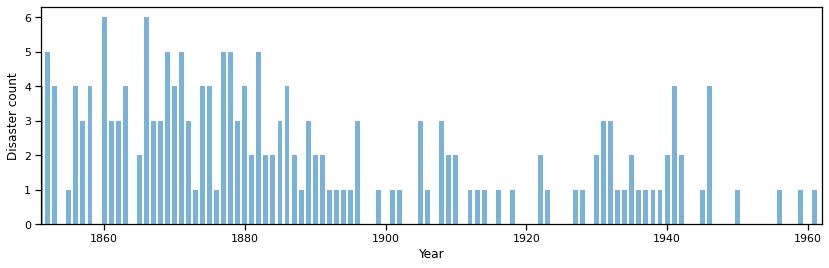

In [4]:
fig, ax = plt.subplots(figsize=(14,4))
ax.bar(year, disasters_data, color="#348ABD", alpha=0.65, width=0.7)
ax.set_xlim(year[0], year[-1]+1)
ax.set_ylabel('Disaster count')
ax.set_xlabel('Year');

In [5]:
with pm.Model() as disasters_model:
    
    ρ = pm.Exponential('ρ', 1)
    η = pm.Exponential('η', 1)
    
    K = η**2 * cov.ExpQuad(1, ρ)
    gp = pm.gp.Latent(cov_func=K)

In [6]:
with disasters_model:
    
    f = gp.prior('f', X=year_ind)

In [7]:
with disasters_model:
    
    λ = pm.Deterministic('λ', pm.math.exp(f))
    
    confirmation = pm.Poisson('confirmation', λ, observed=disasters_data)

In [8]:
with disasters_model:

    trace = pm.sample(1000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f_rotated_, η, ρ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 112 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


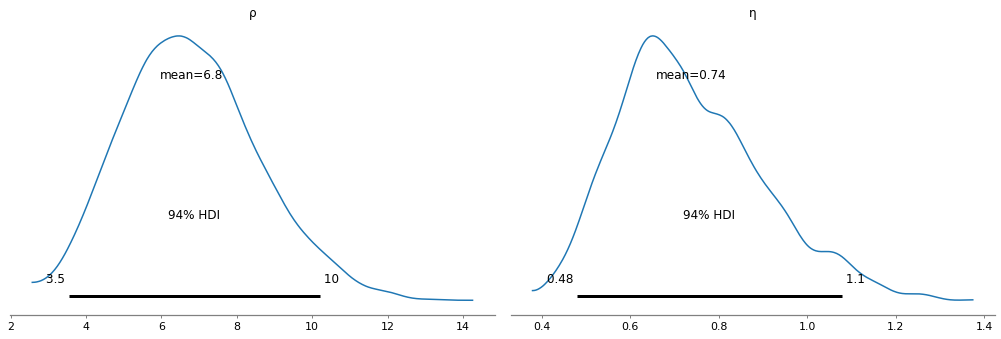

In [9]:
az.plot_posterior(trace, var_names=['ρ', 'η']);

In [10]:
years = (year - year.min())

In [12]:
with disasters_model:
    y_pred = pm.sample_posterior_predictive(trace, var_names=["f"], samples=1000)

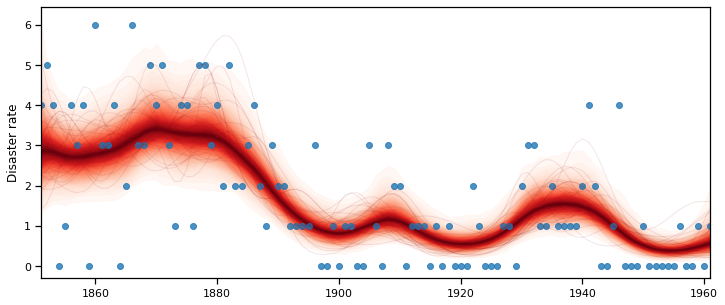

In [13]:
fig, ax = plt.subplots(figsize=(12,5))

pm.gp.util.plot_gp_dist(ax, np.exp(y_pred["f"]), year[:, None])
sns.regplot(year, disasters_data, fit_reg=False, ax=ax)
ax.set_xlim(year.min(), year.max())
ax.set_ylabel('Disaster rate');